<a href="https://colab.research.google.com/github/netmatze/transferlearning/blob/main/transfer_learning_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0

from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models

In [10]:
def preprocess(item):
    image = item['image']
    label = item['label']
    return image, label

def preprocess_dataset(dataset_train, columns : int = 5, rows : int = 5):
    item_list = []
    counter = 0
    for foo in dataset_train:
        image, label = preprocess(foo)
        if counter > columns*rows+1:
          break
        counter += 1
        label_name = info.features['label'].names[label]
        item_dict = {"label": label, "image": image, "label_name": label_name}
        item_list.append(item_dict)

    fig = plt.figure(figsize=(16, 16))
    for i in range(1, columns*rows +1):
        item = item_list[i]
        label = item["label"]
        image = item['image']
        label_name = item["label_name"]
        fig.add_subplot(rows, columns, i)
        plt.imshow(image.numpy()[: ,: , 0].astype(np.float32), cmap = plt.get_cmap("plasma"))
        plt.title(label=label_name)
    plt.show()

def process_dataset_with_model(dataset_train, model, height : int = 32, width : int = 32, columns : int = 5, rows : int = 5):  
    item_list = []
    counter = 0
    for foo in dataset_train:
        image, label = preprocess(foo)
        if counter > columns*rows+1:
          break
        counter += 1
        label_name = info.features['label'].names[label]
        item_dict = {"label": label, "image": image, "label_name": label_name}
        item_list.append(item_dict)

    fig = plt.figure(figsize=(16, 16))
    for i in range(1, columns*rows +1):
        item = item_list[i]
        label = item["label"]
        image = item['image']
        label_name = item["label_name"]

        image_resize = tf.image.resize(image, (height, width)) / 255.0
        image_redim = tf.expand_dims(image_resize, axis=0) #.shape.as_list()
        prediction = model.predict(image_redim)
        b = tf.math.argmax(prediction[0])

        max_item = max(prediction[0])
        index_value = [index for index, item in enumerate(prediction[0]) if item == max_item]
        index_value_int = int(index_value[0])
        
        label_name = info.features['label'].names[label]
        prediction_label_name = info.features['label'].names[index_value_int]

        color = "blue" if label == index_value_int else "red"
      
        label_finished = label_name + ' ' + str(label.numpy()) + ' / ' + prediction_label_name + ' ' + str(index_value_int) + ' '

        fig.add_subplot(rows, columns, i)
        plt.imshow(image.numpy()[: ,: , 0].astype(np.float32), cmap = plt.get_cmap("plasma"))
        plt.title(label=label_finished, color=color)
    plt.show()

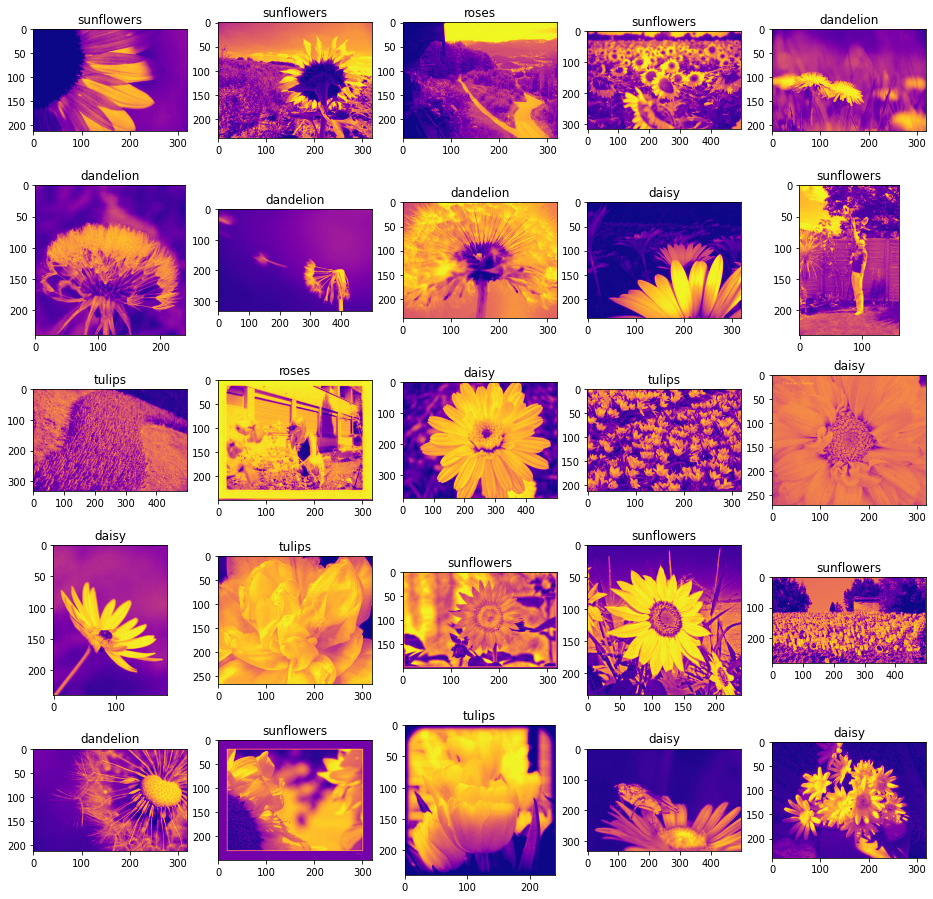

In [12]:
# load tf_flowers dataset



dataset_name = 'tf_flowers'

datasets, info = tfds.load(name=dataset_name, with_info=True)
dataset_train = datasets['train']

preprocess_dataset(dataset_train)

(train_ds, test_ds), dataset_info = tfds.load(dataset_name, 
                                              with_info=True, 
                                              as_supervised=True, 
                                              split=["train[:80%]", "train[:20%]"])

number_of_classes = dataset_info.features['label'].num_classes
num_training_examples = 0
num_validation_examples = 0

for _ in train_ds:
    num_training_examples +=1

for _ in test_ds:
    num_validation_examples +=1

IMAGE_RES = 224
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

BATCH_SIZE = 32
train_ds = train_ds.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
test_ds = test_ds.map(format_image).batch(BATCH_SIZE).prefetch(1)

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

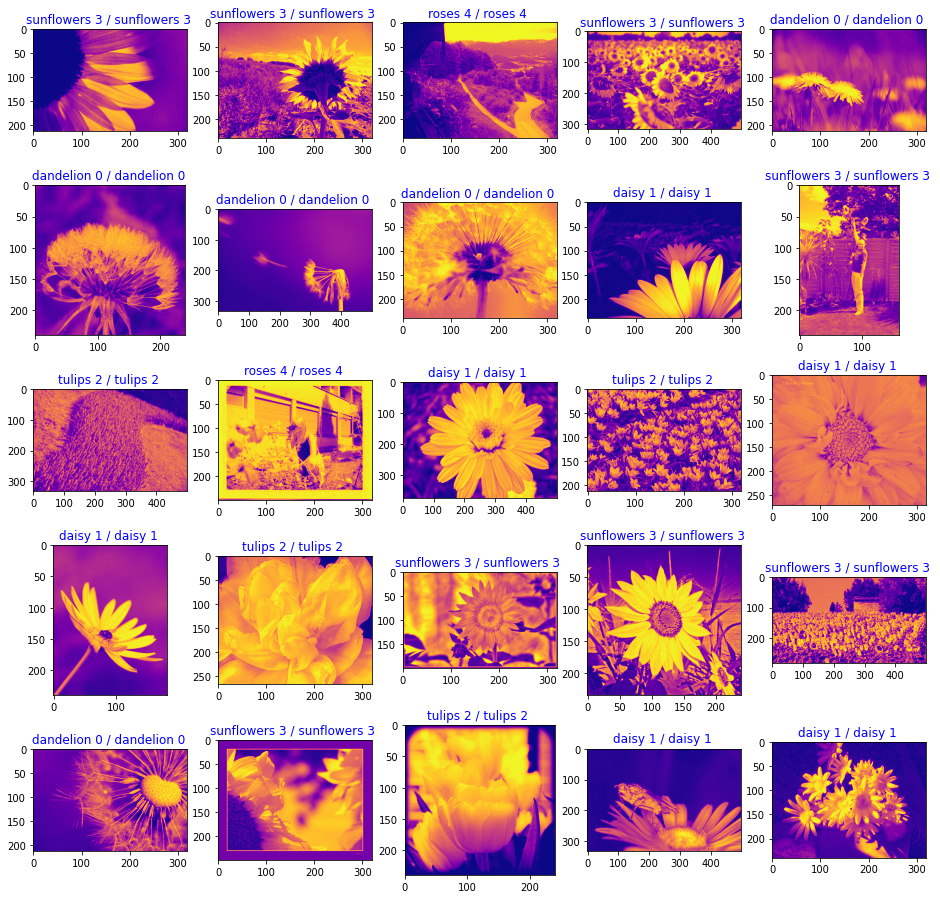

In [6]:
# VGG16/VGG19/MobleNetV2/EfficientNetV2B0/resnet_v2_50
base_model = tf.keras.applications.vgg16.VGG16(             
  weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = tf.keras.applications.vgg19.VGG19(             
#     weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = tf.keras.applications.resnet50.ResNet50(             
#     weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
#     weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(             
#     weights = 'imagenet', include_preprocessing = False, include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False ## Not trainable weights

# Freeze four convolution blocks
# for layer in base_model.layers[:140]:
#     layer.trainable = False

# Make sure you have frozen the correct layers
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name, layer.trainable)

base_model.summary()

model = tf.keras.Sequential()
model.add(base_model)
model.add(layers.GlobalMaxPool2D())
model.add(layers.Dense(5, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=5e-2)

loss = tf.keras.losses.SparseCategoricalCrossentropy()

metrics = ['accuracy']

model.compile(
    optimizer=opt,
    loss=loss,
    metrics=metrics
)

model.summary()

learning_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=5, verbose=1, mode='max', min_lr=5e-7)

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

EPOCHS = 35

history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds, callbacks=[learning_reduce,early_stopping])

print("Evaluate on train data")
results = model.evaluate(train_ds, batch_size=32)
print("train loss, train acc:", results)

print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=32)
print("test loss, test acc:", results)

process_dataset_with_model(dataset_train, model, height=224, width=224)